<h1>PUBG Match Data Insights</h1>
<h3>Brandon Myers</h3>

Player Unknown's BattleGrounds, or PUBG was the first mainstream game to kick off the battle royale genre. 100 players drop onto an open world and fight in a shrinking zone until 1 comes out on top.

I love the game as it has a very nostalgic place in my heart (despite being only 6 years old) and I have a lot of fond memories with friends on the game. I wanted to see what factors contribute to a player place higher in the match. Specific weapons, playstyles, landing location, etc.

The source of the data is the PUBG API, collected by the game as people play it. It could be valuable to gain insights on the game that you otherwise couldn't.

The data includes players, player stats, match history, leaderboards, specific matches, telemetry events within matches, etc. I'm going to use anything I believe would be interesting to observe in relation to how a player performs in a match.

I will be using matches gathered from some of the top 500 players on the leaderboard for solo matches, exclusively on the map Erangel. I chose this map because it was originally the only map in the game, and is also the most recognizable.

In [1]:
import pandas as pd
import json
import requests
import base64
import urllib
import numpy
import matplotlib.pyplot as plt

Reading in the api key

In [2]:
app_key = pd.read_csv("keys/PUBG.txt")

Creating api call function and header

In [3]:
def api_call(endpoint_url, api_header):
    response = requests.get(endpoint_url, headers = api_header)
    print(response.status_code)
    return response.json()

In [4]:
header = {'Authorization':'Bearer {}'.format(app_key['Key'].iloc[0]), 'Accept':'application/vnd.api+json'}

Testing the call

In [5]:
test = api_call("https://api.pubg.com/shards/steam/players?filter[playerNames]=ChangChunYuanMan", header)
test_df = pd.DataFrame(test['data'][0])
test_df

200


,type,id,attributes,relationships,links
stats,player,account.619b02706fc04dcea87889fb2e621f42,None,NaN,NaN
titleId,player,account.619b02706fc04dcea87889fb2e621f42,pubg,NaN,NaN
shardId,player,account.619b02706fc04dcea87889fb2e621f42,steam,NaN,NaN
patchVersion,player,account.619b02706fc04dcea87889fb2e621f42,,NaN,NaN
banType,player,account.619b02706fc04dcea87889fb2e621f42,Innocent,NaN,NaN
clanId,player,account.619b02706fc04dcea87889fb2e621f42,clan.b02c3427046d433d86fd9f0f4924b0da,NaN,NaN
name,player,account.619b02706fc04dcea87889fb2e621f42,ChangChunYuanMan,NaN,NaN
assets,player,account.619b02706fc04dcea87889fb2e621f42,NaN,{'data': []},NaN
matches,player,account.619b02706fc04dcea87889fb2e621f42,NaN,"{'data': [{'type': 'match', 'id': '5529286a-ac...",NaN
self,player,account.619b02706fc04dcea87889fb2e621f42,NaN,NaN,https://api.pubg.com/shards/steam/players/acco...


In [6]:
test_df['relationships']['matches']

{'data': [{'type': 'match', 'id': '5529286a-ac6a-4f7f-801f-85d61aaa4ea1'}]}

Getting data for this specific match

In [7]:
thematch = api_call("https://api.pubg.com/shards/steam/matches/d146ac2a-c5a4-42ea-be4c-5f4f8e8d6438", header)

200


Getting player stats

In [8]:
matchdf = pd.DataFrame(thematch['included'])
stats_df = pd.DataFrame(matchdf['attributes'][0])
stats_df

,actor,shardId,stats
DBNOs,,steam,4
assists,,steam,1
boosts,,steam,9
damageDealt,,steam,551.88306
deathType,,steam,byplayer
headshotKills,,steam,1
heals,,steam,21
killPlace,,steam,6
killStreaks,,steam,2
kills,,steam,4


Trying to get telemetry data, starting with the id for it

In [9]:
thematch['data']['relationships']['assets']

{'data': [{'type': 'asset', 'id': '7420bd1b-ab41-11ef-81fa-9a6b738fb9e6'}]}

Getting the index for the address

In [10]:
matchdf[matchdf['id'] == '7420bd1b-ab41-11ef-81fa-9a6b738fb9e6']['attributes']

78    {'name': 'telemetry', 'description': '', 'crea...
Name: attributes, dtype: object

Creating a dataframe out of the telemetry data (Thanks for the help here your solution was pretty much dead on)

In [11]:
URL = matchdf[matchdf['id'] == '7420bd1b-ab41-11ef-81fa-9a6b738fb9e6']['attributes'][78]['URL']
telemetry = pd.read_json(URL)
tele_df = pd.DataFrame(telemetry)

_D is the Time <br>
_T is the type of event <br>
common is the status of the current match, isGame = 0 is before match start, 0.1 is on the plane, 0.5 is before zone, 1 is the first zone appears, 1.5 is when it shrinks, 2 is when the next one starts, and so on <br>
Character is info about the player the event refers to <br> Mostly everything else is specific to the event type

In [101]:
tele_df.head(8)

,MatchId,PingQuality,_D,_T,accountId,common,character,vehicle,elapsedTime,numAlivePlayers,...,wheelIndex,carePackageUniqueId,carePackageName,swimDistance,maxSwimDepthOfWater,instigator,riders,drivers,gameResultOnFinished,allWeaponStats
0,match.bro.official.pc-2018-32.steam.squad.sea....,,2024-11-25T14:57:17.1932798Z,LogMatchDefinition,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2024-11-25T14:56:06.904Z,LogPlayerLogin,account.dae09a8ecb124a869bd43b4c7992c0f3,{'isGame': 0},NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2024-11-25T14:56:06.922Z,LogPlayerCreate,NaN,{'isGame': 0},"{'name': 'QIU-ARVIN', 'teamId': 12, 'health': ...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2024-11-25T14:56:06.957Z,LogPlayerLogin,account.b852c5611a894ffdb6662fa616c3e250,{'isGame': 0},NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2024-11-25T14:56:06.970Z,LogPlayerCreate,NaN,{'isGame': 0},"{'name': 'LCCSU', 'teamId': 4, 'health': 100, ...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2024-11-25T14:56:07.019Z,LogPlayerLogin,account.3955c6c52e2044288800dca5b3c81a74,{'isGame': 0},NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,2024-11-25T14:56:07.033Z,LogPlayerCreate,NaN,{'isGame': 0},"{'name': 'Shiqi-_-17_', 'teamId': 16, 'health'...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,2024-11-25T14:56:07.039Z,LogPlayerLogin,account.c4c3aef553434ca790df1f9928641a31,{'isGame': 0},NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I wanted to figure out how to get a list of all the specific types of event. I had a lot of trouble figuring out how to locate the index of a row based on its value, but stack overflow came in clutch as usual

In [13]:
tele_df['_T'].index[tele_df['_T']=='LogParachuteLanding'].tolist()

[2215,
 2231,
 2241,
 2245,
 2247,
 2251,
 2267,
 2269,
 2288,
 2298,
 2319,
 2322,
 2369,
 2375,
 2427,
 2431,
 2467,
 2472,
 2475,
 2487,
 2497,
 2499,
 2501,
 2503,
 2510,
 2513,
 2518,
 2540,
 2563,
 2601,
 2614,
 2621,
 2635,
 2645,
 2697,
 2709,
 2776,
 2795,
 2844,
 2879,
 2906,
 2925,
 2961,
 2972,
 2996,
 3005,
 3060,
 3167,
 3186,
 3194,
 3219,
 3237,
 3247,
 3250,
 3252,
 3260,
 3280,
 3334,
 3354,
 3362,
 3395,
 3446,
 3462,
 3486,
 3512,
 3514,
 3523,
 3528,
 3545,
 3566,
 3569,
 3591,
 3620,
 3630,
 3652,
 3690,
 3735,
 3750,
 3798,
 3841,
 3859,
 3875,
 3896,
 3927,
 4042,
 4168,
 4193,
 4231,
 4245,
 4269,
 4291,
 4337,
 4343,
 4546,
 4987,
 5096,
 5323,
 5379,
 5804,
 6181,
 7117,
 7836,
 7898,
 8246,
 13594,
 25211,
 25511,
 25534,
 25631,
 25653,
 30566,
 30599,
 30616,
 30674,
 30820,
 35239,
 35363,
 36957,
 40822,
 40909,
 46196,
 46280,
 48778]

Here I can get the player behind the event and where it happened

In [14]:
tele_df['_D'][2156]
tele_df.iloc[2156]['character']

{'name': 'GnartuhT',
 'teamId': 15,
 'health': 100,
 'location': {'x': 421232.09375, 'y': 412990.25, 'z': 119103.4375},
 'ranking': 0,
 'individualRanking': 0,
 'accountId': 'account.641ff10babba4b81a6a7b7cbf6a6f64e',
 'isInBlueZone': False,
 'isInRedZone': False,
 'inSpecialZone': 'None',
 'isInVehicle': False,
 'zone': [],
 'type': 'user'}

I need to get the season id for the leaderboard I wanna get

In [195]:
#api_call("https://api.pubg.com/shards/steam/seasons/", header)

The most recent leaderboard that works is season 6??? It is currently season 33.

In [194]:
leaderboard = api_call("https://api.pubg.com/shards/pc-na/leaderboards/division.bro.official.pc-2018-06/solo", header)

200


In [17]:
leaderboard.keys()

leader_df = pd.DataFrame(leaderboard['data']['relationships']['players']['data'])
leader_df

,type,id
0,player,account.2f6161f9becd4f8d9bcac25c5f049be8
1,player,account.a2465801e62143b3b1fca6cd29949889
2,player,account.ae876e3afcd243b4b6f3b96c6d306d92
3,player,account.a33b5918828d48dc93d68f6b3429e9e9
4,player,account.52aa8c14e05c45eea359fe62c619fc71
...,...,...
412,player,account.d602c3f9588c4c55bbf914effb3293c0
413,player,account.27301753c3c041058727fac8c30ac10e
414,player,account.51c9e536ce604b4f9ec35332b73f15eb
415,player,account.0c370d93cd484835b4dc99c72302cd8b


Here I can see that I can get recent matches from a player

In [76]:
player = api_call("https://api.pubg.com/shards/steam/players/"+leader_df['id'][15], header)
player

200


{'data': {'type': 'player',
  'id': 'account.45c7abec405844ec9f577f38cf8a3c06',
  'attributes': {'name': 'AIIEN6666666',
   'stats': None,
   'titleId': 'pubg',
   'shardId': 'steam',
   'patchVersion': '',
   'banType': 'Innocent',
   'clanId': ''},
  'relationships': {'assets': {'data': []},
   'matches': {'data': [{'type': 'match',
      'id': 'cf268290-f31b-496a-9a2a-a80f86903445'},
     {'type': 'match', 'id': '3cb8f685-2139-49e0-bf7c-e90c724db8d0'},
     {'type': 'match', 'id': 'e1a9007e-e516-4e7e-9279-5405fbaa0169'},
     {'type': 'match', 'id': '02f6ab64-ca10-4e34-9cc7-866cd6fbb810'},
     {'type': 'match', 'id': '801d1445-28de-4077-919d-d0c9588d2e45'}]}},
  'links': {'self': 'https://api.pubg.com/shards/steam/players/account.45c7abec405844ec9f577f38cf8a3c06',
   'schema': ''}},
 'links': {'self': 'https://api.pubg.com/shards/steam/players/account.45c7abec405844ec9f577f38cf8a3c06'},
 'meta': {}}

Getting a test match

In [102]:
idofmatch = thematch['data']['relationships']['assets']['data'][0]['id']

Figuring out how to find telemetry data

In [106]:
match_df = pd.DataFrame(thematch['included'])
indexx = match_df[match_df['id'] == idofmatch]['attributes'].index[0]

Making a dataframe out of said telemetry data

In [27]:
URLfound = match_df[match_df['id'] == idofmatch]['attributes'][indexx]['URL']
tele = pd.read_json(URLfound)
tele_dff = pd.DataFrame(tele)

Testing getting a list of specific events

In [197]:
deaths = tele_dff['_T'].index[tele_dff['_T']=='LogPlayerKillV2'].tolist()

Now making a new dataframe that I can expand upon, creating my own columns and adding rows from the telemetry dataframe <br> I also used this as a testing ground for finding some of the specific data I need at the bottom

In [120]:
rankings = pd.DataFrame()
tele_dff.iloc[deaths[98]]['victim']
for x in range(len(deaths)):
    rankings = pd.concat([rankings, pd.DataFrame({
    "Position": [tele_dff.iloc[deaths[x]]['victim']['ranking']],
    "Player": [tele_dff.iloc[deaths[x]]['victim']['name']],
    "Type": [tele_dff.iloc[deaths[x]]['victim']['type']],
    "Death Location": [tele_dff.iloc[deaths[x]]['victim']['location']],
    "Death Reason": [tele_dff.iloc[deaths[x]]['killerDamageInfo']['damageReason']]
    
})], ignore_index=True)



kills = pd.DataFrame()

for x in range(len(deaths)):
    if not(tele_dff.iloc[deaths[x]]['killerDamageInfo']['damageCauserName']==''):
        kills = pd.concat([kills, pd.DataFrame({
        "Player": [tele_dff.iloc[deaths[x]]['killer']['name']],
        "Weapons Used": [tele_dff.iloc[deaths[x]]['killerDamageInfo']['damageCauserName']],
        })], ignore_index=True)

kills = kills.groupby('Player')['Weapons Used'].apply(list).reset_index()
#test = pd.DataFrame(tele_dff.iloc[deaths[98]]['victim'])
#test
#tele_dff.iloc[deaths[98]]['victim']


#tele_dff.iloc[deaths[98]]['killerDamageInfo']['damageCauserName']
#tele_dff.iloc[deaths[84]]['dBNODamageInfo']['damageReason']
#tele_dff.iloc[deaths[106]]['killerDamageInfo']['damageCauserName']
rankings.head()

,Position,Player,Type,Death Location,Death Reason
0,0,baizai66,user,"{'x': 632500.0625, 'y': 611775.375, 'z': 62.65...",TorsoShot
1,0,QIU-ARVIN,user,"{'x': 628615.9375, 'y': 610800.25, 'z': 62.159...",TorsoShot
2,29,dhjuidsaN,user,"{'x': 623006.3125, 'y': 613199.875, 'z': 90.16...",HeadShot
3,0,xgnb1324,user,"{'x': 624214.875, 'y': 612689.875, 'z': 62.159...",TorsoShot
4,0,wahahahahaa123,user,"{'x': 624531.8125, 'y': 612942.5, 'z': 62.1500...",PelvisShot


In [118]:
kills.head()

,Player,Weapons Used
0,1RRtCn8Q1pwsI,[WeapHK416_C]
1,1stLandingBOX,"[WeapBerylM762_C, WeapBerylM762_C]"
2,98kdeemeng,[WeapUZI_C]
3,Ayiyi-,[WeapHK416_C]
4,BIEDAWOAAA---,"[WeapFNFal_C, WeapM16A4_C, WeapM249_C, WeapM24..."


Getting player stats from the end of the match and combining it with previous dataframe

In [199]:
matchend = tele_dff['_T'].index[tele_dff['_T']=='LogMatchEnd'][0]

newranking = pd.DataFrame()
info = tele_dff.iloc[matchend]['characters']
for x in range(0,100):
    newranking = pd.concat([newranking, pd.DataFrame({
    "Position": [info[x]['character']['ranking']],
    "Player": [info[x]['character']['name']],
    "Type": [info[x]['character']['type']]
    })], ignore_index=True)

newnew = pd.concat([rankings,newranking], ignore_index=True, )
newnewtest = rankings.merge(newranking, how='outer')
newnewtest.head()

,Position,Player,Type,Death Location,Death Reason
0,0,1RRtCn8Q1pwsI,user,"{'x': 378320.625, 'y': 135772.546875, 'z': 502...",TorsoShot
1,0,4AM_664859,user,"{'x': 204814.59375, 'y': 276543.59375, 'z': 11...",TorsoShot
2,0,77sevenGG,user,"{'x': 464852.15625, 'y': 650780.3125, 'z': 55....",TorsoShot
3,0,98kdeemeng,user,"{'x': 464352.71875, 'y': 647857.875, 'z': 55.9...",LegShot
4,0,Adoro-,user,"{'x': 516555.90625, 'y': 224429.453125, 'z': 2...",HeadShot


Getting match stats for all of the players

In [129]:
participants = match_df.loc[match_df['type'] == 'participant'].index.tolist()

participants
newdf = pd.DataFrame()
for x in participants:

    newdf = pd.concat([newdf, pd.DataFrame({
    "Player": [match_df['attributes'][x]['stats']['name']],
    "Kills": [match_df['attributes'][x]['stats']['kills']],
    "Dmg Dealt": [match_df['attributes'][x]['stats']['damageDealt']],
    "Dist Walked": [match_df['attributes'][x]['stats']['walkDistance']],
    "Longest Kill": [match_df['attributes'][x]['stats']['longestKill']],
    "Time Survived": [match_df['attributes'][x]['stats']['timeSurvived']],
    })], ignore_index=True)

newdf.head()

,Player,Kills,Dmg Dealt,Dist Walked,Longest Kill,Time Survived
0,WoFang-Bu-Xia-Ta,4,551.883060,3890.78470,50.13171,1412
1,HuYa-13988224,0,57.809998,96.80203,0.00000,186
2,YuanQiSaoNan,1,80.741880,1392.00170,13.87078,1234
3,DucTuyen2207,0,99.999990,376.00797,0.00000,225
4,TEQUILAHYZ,1,328.288150,1446.34950,143.51414,1274


Merging them yet again

In [127]:
newestdf = newnewtest.merge(newdf,how='left')
newestdf.head(10)

,Position,Player,Type,Death Location,Death Reason,Kills,Dmg Dealt,Dist Walked,Longest Kill,Time Survived
0,0,1RRtCn8Q1pwsI,user,"{'x': 378320.625, 'y': 135772.546875, 'z': 502...",TorsoShot,1,324.00000,105.51625,36.783024,362
1,0,4AM_664859,user,"{'x': 204814.59375, 'y': 276543.59375, 'z': 11...",TorsoShot,0,80.99208,445.29320,0.000000,417
2,0,77sevenGG,user,"{'x': 464852.15625, 'y': 650780.3125, 'z': 55....",TorsoShot,0,82.56000,477.58250,0.000000,358
3,0,98kdeemeng,user,"{'x': 464352.71875, 'y': 647857.875, 'z': 55.9...",LegShot,1,172.60000,424.40582,1.383169,311
4,0,Adoro-,user,"{'x': 516555.90625, 'y': 224429.453125, 'z': 2...",HeadShot,0,0.00000,1221.27780,0.000000,1136
5,0,Asong169,user,"{'x': 546110.0625, 'y': 218100.9375, 'z': 745....",PelvisShot,0,57.65000,368.77646,0.000000,1386
6,0,Ayiyi-,user,"{'x': 552605.125, 'y': 200550.59375, 'z': 4381...",HeadShot,1,202.16693,1112.28800,13.151868,1471
7,0,BOTVapeStore69,user,"{'x': 601899.4375, 'y': 478019.03125, 'z': 455...",HeadShot,0,0.00000,204.81879,0.000000,224
8,0,BWRTYQj,user,"{'x': 626137.625, 'y': 605000.625, 'z': 62.159...",TorsoShot,0,56.82600,79.36521,0.000000,133
9,0,Berysay,user,"{'x': 599080.1875, 'y': 477076.1875, 'z': 506....",TorsoShot,0,66.44582,102.22019,0.000000,167


Getting player drop locations

In [130]:
landing = tele_dff['_T'].index[tele_dff['_T']=='LogParachuteLanding'].tolist()

landed_df = pd.DataFrame()
for x in landing:
    landed_df = pd.concat([landed_df, pd.DataFrame({
    "Player": [tele_dff['character'][x]['name']],
    "Landed Location": [tele_dff['character'][x]['location']]
    })], ignore_index=True)

landed_df = landed_df.drop_duplicates(subset=['Player'])
landed_df.head()

,Player,Landed Location
0,baizai66,"{'x': 633402.875, 'y': 612005.5625, 'z': 122.6..."
1,TsukasaHwan,"{'x': 633024.6875, 'y': 612221.6875, 'z': 261...."
2,BIEDAWOAAA---,"{'x': 627861.75, 'y': 609943.25, 'z': 336.8737..."
3,IBBLONG-,"{'x': 629871.875, 'y': 607361, 'z': 447.885314..."
4,Shiqi-_-17_,"{'x': 622950.5625, 'y': 614832.9375, 'z': 395...."


Getting players that looted carepackages throughout the match

In [144]:
carepkg = tele_dff['_T'].index[tele_dff['_T']=='LogItemPickupFromCarepackage'].tolist()

carepkg_df = pd.DataFrame()
for x in carepkg:
    carepkg_df = pd.concat([carepkg_df, pd.DataFrame({
    "Player": [tele_dff['character'][x]['name']],
    "CarepackageLooted": [tele_dff['item'][x]['itemId'][5:-2]],
    })], ignore_index=True, copy=False)

carepkg_df = carepkg_df.groupby('Player')['CarepackageLooted'].apply(list).reset_index()

newestnewdf = newestdf.merge(carepkg_df, how='left')

carepkg_df

,Player,CarepackageLooted
0,1stLandingBOX,"[Head_G_01_Lv3, Back_C_01_Lv3, Armor_C_01_Lv3,..."
1,ht0135,"[Armor_C_01_Lv3, Head_G_01_Lv3]"


Getting players that used vehicles in the match

In [145]:
vehicle_df = pd.DataFrame()

vehicle = tele_dff['_T'].index[tele_dff['_T']=='LogVehicleRide'].tolist()
for x in vehicle:
    if not(tele_dff['vehicle'][x]['vehicleType']=='TransportAircraft'):
        vehicle_df = pd.concat([vehicle_df, pd.DataFrame({
        "Player": [tele_dff['character'][x]['name']],
        "Vehicle Ridden": [tele_dff['vehicle'][x]['vehicleId']],
        })], ignore_index=True, copy=False)
vehicle_df = vehicle_df.drop_duplicates().reset_index()


vehicle_df = vehicle_df.groupby('Player')['Vehicle Ridden'].apply(list).reset_index()

vehicle_df.head()

,Player,Vehicle Ridden
0,1dashuaigeovo,"[Dacia_A_03_v2_Esports_C, Uaz_B_01_C]"
1,Adoro-,[Dacia_A_03_v2_Esports_C]
2,Asong169,[Uaz_B_01_esports_C]
3,Ayiyi-,"[Uaz_B_01_esports_C, BP_BRDM_C]"
4,Bobocet,"[BP_Motorbike_04_C, Dacia_A_03_v2_Esports_C]"


Combining the final dataframes

In [147]:
final = newestnewdf.merge(vehicle_df,how='left')
final.head(10)

,Position,Player,Type,Death Location,Death Reason,Kills,Dmg Dealt,Dist Walked,Longest Kill,Time Survived,CarepackageLooted,Vehicle Ridden
0,0,1RRtCn8Q1pwsI,user,"{'x': 378320.625, 'y': 135772.546875, 'z': 502...",TorsoShot,1,324.00000,105.51625,36.783024,362,NaN,NaN
1,0,4AM_664859,user,"{'x': 204814.59375, 'y': 276543.59375, 'z': 11...",TorsoShot,0,80.99208,445.29320,0.000000,417,NaN,NaN
2,0,77sevenGG,user,"{'x': 464852.15625, 'y': 650780.3125, 'z': 55....",TorsoShot,0,82.56000,477.58250,0.000000,358,NaN,NaN
3,0,98kdeemeng,user,"{'x': 464352.71875, 'y': 647857.875, 'z': 55.9...",LegShot,1,172.60000,424.40582,1.383169,311,NaN,NaN
4,0,Adoro-,user,"{'x': 516555.90625, 'y': 224429.453125, 'z': 2...",HeadShot,0,0.00000,1221.27780,0.000000,1136,NaN,[Dacia_A_03_v2_Esports_C]
5,0,Asong169,user,"{'x': 546110.0625, 'y': 218100.9375, 'z': 745....",PelvisShot,0,57.65000,368.77646,0.000000,1386,NaN,[Uaz_B_01_esports_C]
6,0,Ayiyi-,user,"{'x': 552605.125, 'y': 200550.59375, 'z': 4381...",HeadShot,1,202.16693,1112.28800,13.151868,1471,NaN,"[Uaz_B_01_esports_C, BP_BRDM_C]"
7,0,BOTVapeStore69,user,"{'x': 601899.4375, 'y': 478019.03125, 'z': 455...",HeadShot,0,0.00000,204.81879,0.000000,224,NaN,NaN
8,0,BWRTYQj,user,"{'x': 626137.625, 'y': 605000.625, 'z': 62.159...",TorsoShot,0,56.82600,79.36521,0.000000,133,NaN,NaN
9,0,Berysay,user,"{'x': 599080.1875, 'y': 477076.1875, 'z': 506....",TorsoShot,0,66.44582,102.22019,0.000000,167,NaN,NaN


Basically my entire approach to this was make dataframe > make another and merge > make another and merge, and so on. I don't know if thats the best method but it works for the most part!

Now I have two functions, one to get a specific match

In [37]:
def getmatch(matchid):
    match = api_call('https://api.pubg.com/shards/steam/matches/'+matchid,header)
    match_df = pd.DataFrame(match['included'])

    mapName = match['data']['attributes']['mapName']
    
    idofmatch = match['data']['relationships']['assets']['data'][0]['id']
    indexx = match_df[match_df['id'] == idofmatch]['attributes'].index[0]
    
    URLfound = match_df[match_df['id'] == idofmatch]['attributes'][indexx]['URL']
    tele = pd.read_json(URLfound)
    tele_df = pd.DataFrame(tele)
    return(match_df, tele_df, mapName)

And the other one to collect and compile all the data from said match. Basically taking all my prior work into a single function.

In [38]:
def collect(match_df, tele_df):

    ####### Get all deaths in a match
    
    deaths = tele_df['_T'].index[tele_df['_T']=='LogPlayerKillV2'].tolist()
    
    rankings = pd.DataFrame()
    
    for x in deaths:
        rankings = pd.concat([rankings, pd.DataFrame({
        "Position": [tele_df.iloc[x]['victim']['ranking']],
        "Player": [tele_df.iloc[x]['victim']['name']],
        "Type": [tele_df.iloc[x]['victim']['type']],
        "Death Location": [tele_df.iloc[x]['victim']['location']],
        "Death Reason": [tele_df.iloc[x]['killerDamageInfo']['damageReason']]
        })], ignore_index=True)

    ####### Get all characters in a match
    
    matchend = tele_df['_T'].index[tele_df['_T']=='LogMatchEnd'][0]

    newranking = pd.DataFrame()
    
    info = tele_df.iloc[matchend]['characters']
    
    for x in range(0, len(info)):
        newranking = pd.concat([newranking, pd.DataFrame({
        "Position": [info[x]['character']['ranking']],
        "Player": [info[x]['character']['name']],
        "Type": [info[x]['character']['type']]
        })], ignore_index=True)
    #tele_dff.iloc[25473]['characters'][1]['character']
    
    final_df = rankings.merge(newranking, how='outer')
    
    ####### Get all kills in a match
    
    kills = pd.DataFrame()

    for x in range(len(deaths)):
        if not(tele_df.iloc[deaths[x]]['killerDamageInfo']['damageCauserName']==''):
            kills = pd.concat([kills, pd.DataFrame({
            "Player": [tele_df.iloc[deaths[x]]['killer']['name']],
            "Weapons Used": [tele_df.iloc[deaths[x]]['killerDamageInfo']['damageCauserName'][4:-2]],
            })], ignore_index=True)
    kills = kills.groupby('Player')['Weapons Used'].apply(list).reset_index()
    
    final_df = final_df.merge(kills, how='outer')
    
    ####### Get all characters in a match and their stats
    
    participants = match_df.loc[match_df['type'] == 'participant'].index.tolist()

    participants
    newdf = pd.DataFrame()
    for x in participants:

        newdf = pd.concat([newdf, pd.DataFrame({
        "Player": [match_df['attributes'][x]['stats']['name']],
        "Kills": [match_df['attributes'][x]['stats']['kills']],
        "Dmg Dealt": [match_df['attributes'][x]['stats']['damageDealt']],
        "Dist Walked": [match_df['attributes'][x]['stats']['walkDistance']],
        "Longest Kill": [match_df['attributes'][x]['stats']['longestKill']],
        "Time Survived": [match_df['attributes'][x]['stats']['timeSurvived']],
        })], ignore_index=True)

    final_df = final_df.merge(newdf,how='left')

    ####### Get all landing locations
    
    landing = tele_df['_T'].index[tele_df['_T']=='LogParachuteLanding'].tolist()
    landed_df = pd.DataFrame()
    
    for x in landing:
        landed_df = pd.concat([landed_df, pd.DataFrame({
        "Player": [tele_df['character'][x]['name']],
        "Landed Location": [tele_df['character'][x]['location']]
        })], ignore_index=True)
   
    
    landed_df = landed_df.drop_duplicates(subset=['Player'])

    
    final_df = final_df.merge(landed_df,how='left')

    ####### Get all carepackage pickups
    
    care = tele_df['_T'].index[tele_df['_T']=='LogItemPickupFromCarepackage'].tolist()
    
    care_df = pd.DataFrame()
    
    for x in care:
        care_df = pd.concat([care_df, pd.DataFrame({
        "Player": [tele_df['character'][x]['name']],
        "CarepackageLooted": [tele_df['item'][x]['itemId'][5:-2]]
        })], ignore_index=True, copy=False)


    #care_df = care_df.groupby('Player')['CarepackageLooted'].apply(list).reset_index()
      #I had to ditch care packages for the final dataframe because it kept giving me an error that I had no clue how to resolve
    #final_df = final_df.merge(care_df,how='left')

    ####### Get all vehicles ridden
    
    vehicle_df = pd.DataFrame()

    vehicle = tele_df['_T'].index[tele_df['_T']=='LogVehicleRide'].tolist()
    for x in vehicle:
        if not(tele_df['vehicle'][x]['vehicleType']=='TransportAircraft'):
            vehicle_df = pd.concat([vehicle_df, pd.DataFrame({
            "Player": [tele_df['character'][x]['name']],
            "Vehicle Ridden": [tele_df['vehicle'][x]['vehicleId']]
            })], ignore_index=True, copy=False)
    vehicle_df = vehicle_df.drop_duplicates().reset_index()
    
    
    vehicle_df = vehicle_df.groupby('Player')['Vehicle Ridden'].apply(list).reset_index()
    
    final_df = final_df.merge(vehicle_df,how='left')

    #######
    
    return final_df


The method I was going to use to automate id collection wasn't working so I gathered these manually from some of the top 500 players

In [39]:
match_collection = ['3b84b9dd-6383-4162-94b0-b96c54c403b4',
     'b675b5f3-9f99-443e-959c-4e016ff0f050',
     'bf958047-2c8a-4185-b3f1-7e728c61f699',
     '9544b04d-4038-4578-9306-29649c578e02',
     'c58a44d5-1122-4fce-a3a0-529401a858c7',
     'fccf2ef1-13c0-4d67-bdaa-97eee812d5a6',
     '7477a20c-14c2-45f7-87f5-65a880bd2f17',
     'a4cc422d-2a18-4528-918b-04a26675f1aa',
     '96de0dd6-0286-45aa-a51f-b3f6625e7cbf',
     '74a8119f-c7f3-4266-9b88-34ad768aac7a',
     '2d60d3d9-c8ab-45a4-b16d-04e72cb3bc6f',
     '47f08dcb-2ce3-4493-b6ec-12cc8266fdae',
     '2cd6fc40-40a2-4f62-8fa5-9d9be6b4fde9',
     '5ea35b02-da9f-4106-9608-5c5b711630fb',
     'e73e18e2-aa3e-40ce-b49e-f095e7e7f745',
     '211d0934-aa3a-4ae8-ba3d-6f4242a55528',
     'b0a9db41-a170-4bd1-8ec4-1618628e5a31',
     'af7da6d2-3104-4057-8548-511c120786b6',
     '4262cb27-0506-490f-b62a-523c152eb174',
     '1aa9b774-a952-46de-a9a3-d7b47bb0a38a',
     'b1256999-9075-4d86-86ed-68c9e47c551a',
     '4ee7bacd-c402-488f-87b3-4a4704865919',
     'f674c9ba-5146-48a2-b0dc-0447053606a3',
     '3cf1ba1f-a41d-4037-85df-e07fe810fa5b',
     '0735bda5-174e-43ee-9cd4-7ff98c6663bd',
     '4cdfc06a-0317-4bb0-b669-aa1d48f8f881',
     'e1ed2c9b-b9b7-4d7f-a2cd-4bf3b22fd8d9',
     '9f845b99-f9da-4817-8166-ba15940077e5',
     'ef68c7a9-10b1-4cd5-b548-87108d2d5a44',
     '7423f7f2-4acd-453e-b50e-0c88cd3cc357',
     '0b4adaba-fb20-40c8-8d0e-ffd805457b40',
     '78940f43-0b01-48ea-88a4-e83ef3f46d5d',
     '099175e5-2c19-4ad2-886c-91ecab47ef53',
     '1c4a25b2-432b-43c0-a6b1-1bf9449c36e5',
     'ba4eed5e-5602-4e6b-8e36-ba509bc163ae',
     'a8eb64da-01f1-46c0-8c24-aef9c4bebfa3',
     '1e28a132-5be4-4b4c-a1c0-ee2d6311b683',
     '286c91bf-1b87-4f3b-a445-04b0d46f56e9',
     'c629f704-347f-4108-b0bb-58cdd0abb6f1',
     'eaf82bb1-0a8a-434f-ad3c-003ffb4fafa7',
     '92d4c014-0726-452f-90a3-45078f47ced3',
     'e6da6a6d-092d-4210-a897-c35d9cf35f8b',
     '479d4c95-2516-49aa-98b2-3789279832ac',
     'b85228be-34ce-4624-9a43-a297a76b60da',
     'bce6d36e-8641-4a26-b416-2dc980d0f60d',
     '0b928924-0bf3-4b64-b1f8-9ccebf684c5b',
     '34a2b60a-0eb5-499c-afae-49735e479e18',
     'a28cda17-790d-4a6a-95bd-effdc89f9c9b',
     '502b5f14-89f0-4cbb-b280-f4b9e98d7842',
     'f63e2c97-559b-4069-9a34-de900b86225f',
     'b25f0fee-fba3-4b56-9d4b-374d5d48c64a',
     '8f4279ee-36b9-4334-8bac-c7c7c3bd89e9',
     '3d470152-3707-452a-893a-05d1cd3f3a25',
     '27989b7a-a373-4b7b-ac40-eba679aaaa2c',
     '5a66c05f-7ce0-45b2-b6f3-26a0f7e23775',
     'a3772cdf-f9fe-40ad-975a-dcf9f72b707d',
     '34c72043-27a7-4313-8ff9-0d442dd6e7dc',
     '02f6ab64-ca10-4e34-9cc7-866cd6fbb810',
     '801d1445-28de-4077-919d-d0c9588d2e45',
     '4173f104-c89b-4dd4-aa27-43c9b7bb01a3',
     'a5fd33ed-9b38-4d3d-8c58-19e17260adb3',
     '801f67d4-d08b-46a0-b1ad-e5299eba55d4',
     'dd0b0708-a28e-4015-ba3b-8a7df9a5cb7a',
     '24b2af19-1483-46ea-9ebe-947dc4678e65',
     'fa6b715c-3059-4bbb-a50e-65a4ee21566e']


Here I will make the final dataframe, and make sure I'm only getting matches on the map Erangel (id: Baltic_Main)

In [ ]:
bigboy_df = pd.DataFrame()

for x in range(len(match_collection)-1):
    if getmatch(match_collection[x])[2] == 'Baltic_Main':
        bigboy_df = pd.concat([bigboy_df, collect(getmatch(match_collection[x])[0],getmatch(match_collection[x])[1])], ignore_index=True)

Reordering columns

In [193]:
bigboy_df = bigboy_df[['Player', 'Position', 'Type', 'Landed Location', 'Dmg Dealt', 'Kills', 'Longest Kill','Weapons Used', 'Dist Walked', 'Vehicle Ridden', 'Death Reason', 'Death Location','Time Survived']]
bigboy_df.head()

,Player,Position,Type,Landed Location,Dmg Dealt,Kills,Longest Kill,Weapons Used,Dist Walked,Vehicle Ridden,Death Reason,Death Location,Time Survived
0,1Nana-,95,user,"{'x': 215421.921875, 'y': 396051.125, 'z': 750...",300.000000,3,14.654496,"[AK47, AK47, AK47]",59.02305,NaN,TorsoShot,"{'x': 220704.046875, 'y': 393262.375, 'z': 169...",91
1,ABS_12-32,75,user_ai,"{'x': 509058.84375, 'y': 242978.46875, 'z': 21...",0.000000,0,0.000000,NaN,345.50632,NaN,,"{'x': 510744.5625, 'y': 224370.625, 'z': -543....",441
2,AMIRRA__78,70,user_ai,"{'x': 301582.3125, 'y': 374320.90625, 'z': 142...",100.000000,1,0.000000,[M16A4],612.94470,NaN,LegShot,"{'x': 314792.0625, 'y': 351998.4375, 'z': 869....",468
3,Abr_ilau,49,user_ai,"{'x': 637668.8125, 'y': 324917.3125, 'z': 897....",0.000000,0,0.000000,NaN,1649.80760,NaN,TorsoShot,"{'x': 569164.3125, 'y': 264286.09375, 'z': 798...",741
4,AbsCati_pm,63,user_ai,"{'x': 233952.15625, 'y': 374006.46875, 'z': 62...",22.032198,0,0.000000,NaN,1316.22700,NaN,TorsoShot,"{'x': 264574.75, 'y': 315680.21875, 'z': 4515....",630


In [157]:
#bigboy_df[(bigboy_df['Position']==1)].head()

Here's a clean view of the map to reference later

<img src='erangel.png'>

Editing a colormap to have transparency later

In [48]:
from matplotlib.colors import ListedColormap

cmap = plt.cm.inferno
my_cmap = cmap(numpy.arange(cmap.N))
my_cmap[:,-1] = numpy.linspace(0.7, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

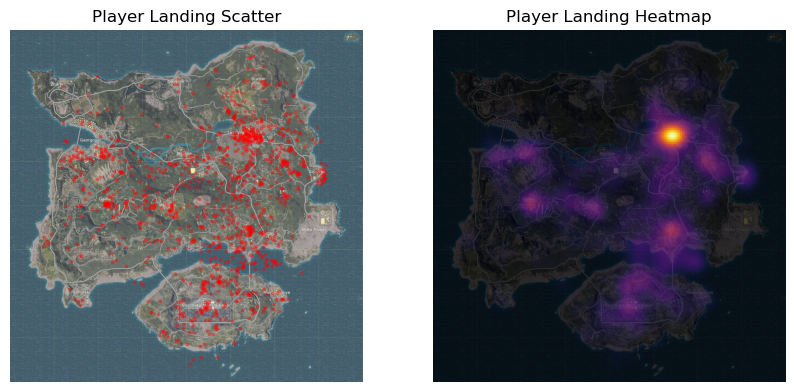

In [158]:
from scipy.ndimage import gaussian_filter

xloc = bigboy_df['Landed Location'].apply(pd.Series)['x']
yloc = bigboy_df['Landed Location'].apply(pd.Series)['y']

fig3, ax3 = plt.subplots(1,2, figsize=(10, 6))

extent = (0, 800000, 800000, 0)


ax3[0].scatter(xloc,yloc, s=3, c='red',alpha=0.3)
ax3[0].imshow(im, alpha=0.8, extent=extent)
ax3[0].set_title('Player Landing Scatter')
ax3[0].axis('off')

heatmap, xedges, yedges = numpy.histogram2d(xloc, yloc, bins=150, range=[[0, 800000], [0, 800000]])
heatmap = gaussian_filter(heatmap, 3)
ax3[1].imshow(im, alpha=1, extent=extent)
ax3[1].imshow(heatmap.T, extent=extent,cmap=my_cmap)
ax3[1].set_title('Player Landing Heatmap')
ax3[1].axis('off')

plt.show()

Here I've plotted player landing locations, one in a scatterplot and one using a heatmap<br>
Its very clear that players favor the top right city of Yasnaya Polyana (The yellow glow on the heatmap)
There are also significant players in the bottom right city of Mylta near the bridge, as well as Georgopol, Gatka, and Pochinki towards the left.<br>
I'm surprised there is little to no activity at the school, the big yellow square the in center of the map. This used to be the most popular hot drop location due to its wide range of loot and quick action, with around 20 or so players typically landing there.

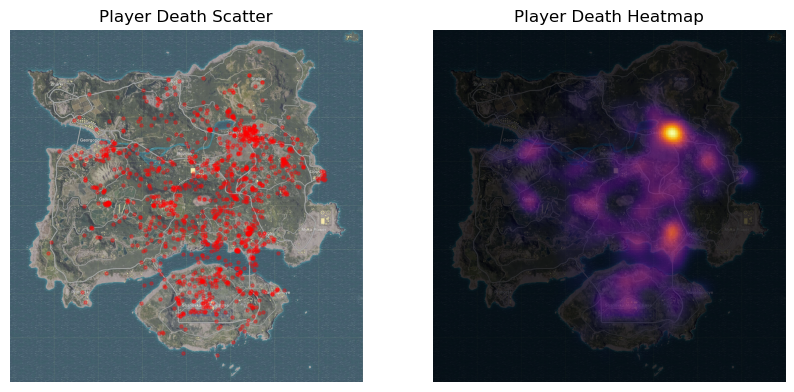

In [51]:
xloc = bigboy_df.dropna(subset='Death Location')['Death Location'].apply(pd.Series)['x']
yloc = bigboy_df.dropna(subset='Death Location')['Death Location'].apply(pd.Series)['y']

fig4, ax4 = plt.subplots(1,2, figsize=(10, 6))


ax4[0].scatter(xloc,yloc, s=5, c='red',alpha=0.3)
ax4[0].imshow(im, alpha=0.8, extent=extent)
ax4[0].set_title('Player Death Scatter')
ax4[0].axis('off')

heatmap, xedges, yedges = numpy.histogram2d(xloc, yloc, bins=150, range=[[0, 800000], [0, 800000]])
heatmap = gaussian_filter(heatmap, 3)
ax4[1].imshow(im, alpha=1, extent=extent)
ax4[1].imshow(heatmap.T, extent=extent,cmap=my_cmap)
ax4[1].set_title('Player Death Heatmap')
ax4[1].axis('off')

plt.show()

The death scatter map has a lot in common with the landing map, which makes sense, the key difference being the dots are now closer to the center, moving along with the games bluezone.

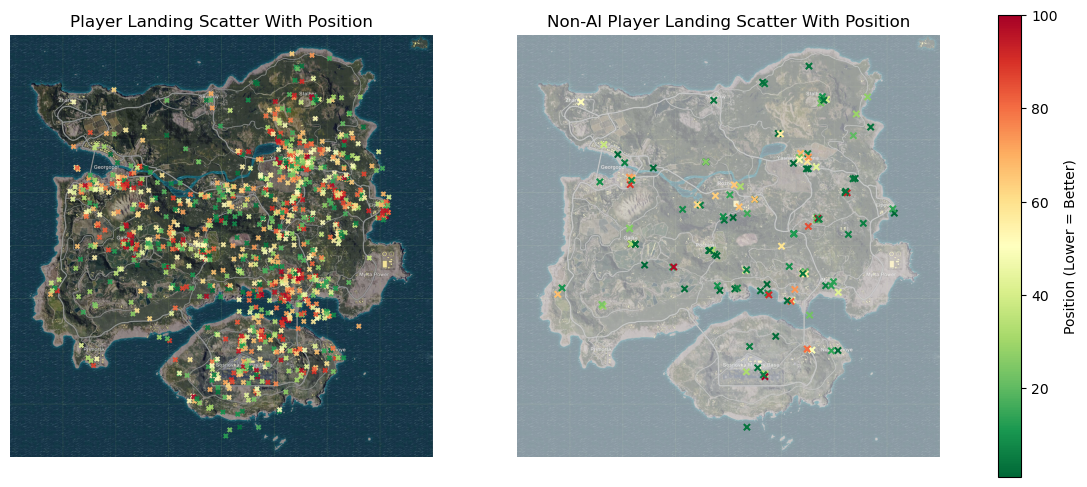

In [162]:
xloc = bigboy_df['Landed Location'].apply(pd.Series)['x']
yloc = bigboy_df['Landed Location'].apply(pd.Series)['y']
posit = bigboy_df['Position']

xloc_r = bigboy_df[(bigboy_df['Type']=='user')]['Landed Location'].apply(pd.Series)['x']
yloc_r= bigboy_df[(bigboy_df['Type']=='user')]['Landed Location'].apply(pd.Series)['y']
posit_r = bigboy_df[(bigboy_df['Type']=='user')]['Position']

fig5, ax5 = plt.subplots(1,2,figsize=(15, 6))

extent = (0, 800000, 800000, 0)

p = ax5[0].scatter(xloc,yloc, s=9,alpha=0.9, c=posit, cmap='RdYlGn_r', marker='x')
ax5[0].imshow(im, alpha=1, extent=extent)
ax5[0].set_title('Player Landing Scatter With Position')
ax5[0].axis('off')

p = ax5[1].scatter(xloc_r,yloc_r, s=20,alpha=1, c=posit_r, cmap='RdYlGn_r', marker='x')
ax5[1].imshow(im, alpha=0.5, extent=extent)
ax5[1].set_title('Non-AI Player Landing Scatter With Position')
ax5[1].axis('off')

#p = ax.scatter(x, y, c=y, cmap='cmo.deep')
fig5.colorbar(p,ax=ax5,orientation='vertical',label='Position (Lower = Better)')

plt.show()

When I first saw the chart on the left, I believed that players who landed in more rural areas, away from big towns, made it farther into the match. As all the red and yellow markers tend to be in big cities. But once you remove AI from the equation, some players still make it pretty far even when landing in popular areas. Also by only looking at real players, I realize how limited my dataset is.

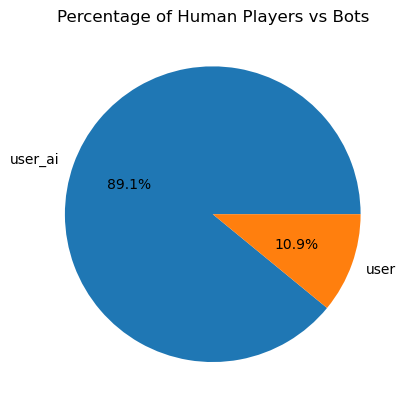

In [163]:
ai_df = pd.DataFrame(bigboy_df['Type'].value_counts(normalize=True).reset_index())
fig8, ax8 = plt.subplots()
ax8.pie(ai_df['proportion'],labels=ai_df['Type'], autopct='%1.1f%%')
ax8.set_title('Percentage of Human Players vs Bots')
plt.show()

The previous chart prompted me to look at just how many bots are actually in these matches. On average, only 11 players in a match are real! This is very disappointing, especially when the game still peaks at 700,000+ players daily on pc alone! 

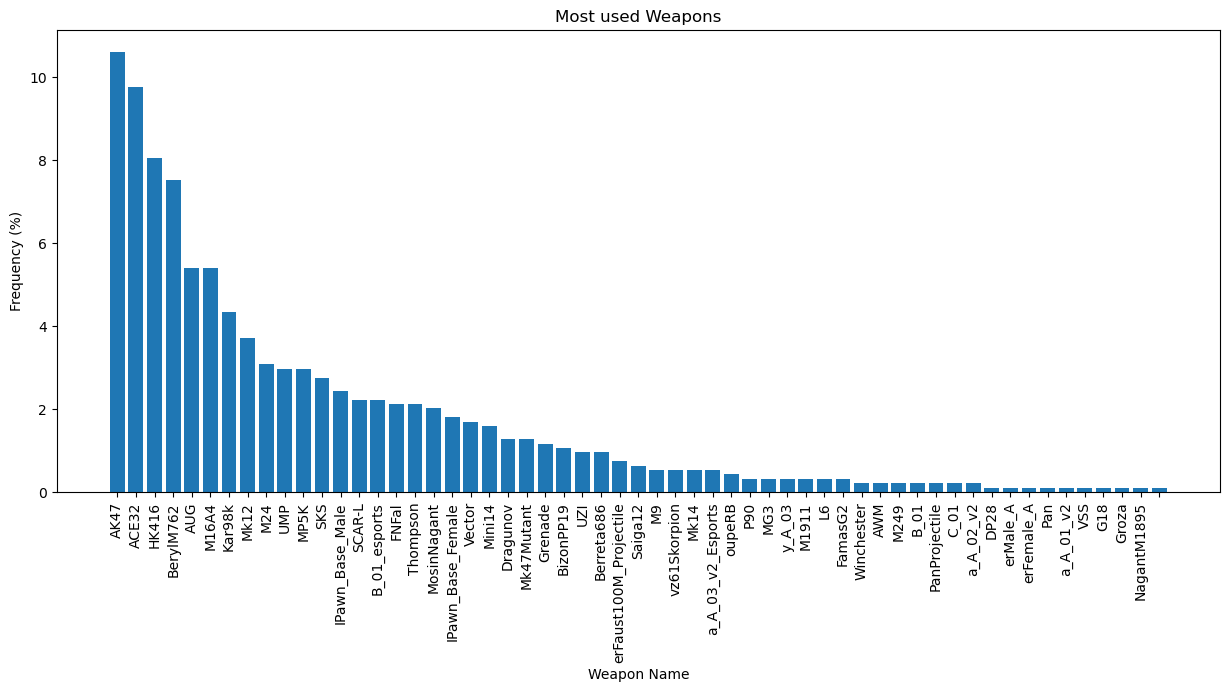

In [57]:
weapons_df = pd.DataFrame(bigboy_df['Weapons Used']).explode('Weapons Used', ignore_index = True)
freq_df = pd.DataFrame(weapons_df.value_counts('Weapons Used', dropna=True).reset_index())
norm_df = pd.DataFrame(weapons_df.value_counts('Weapons Used', dropna=True, normalize=True).reset_index())
fig6, ax6 = plt.subplots(figsize=(15, 6))


ax6.bar(freq_df['Weapons Used'],norm_df['proportion']*100)
ax6.set_title('Most used Weapons')
plt.ylabel('Frequency (%)')
plt.xlabel('Weapon Name')
plt.xticks(rotation=90)
plt.show()

Here are the most killed with weapons by percentage.

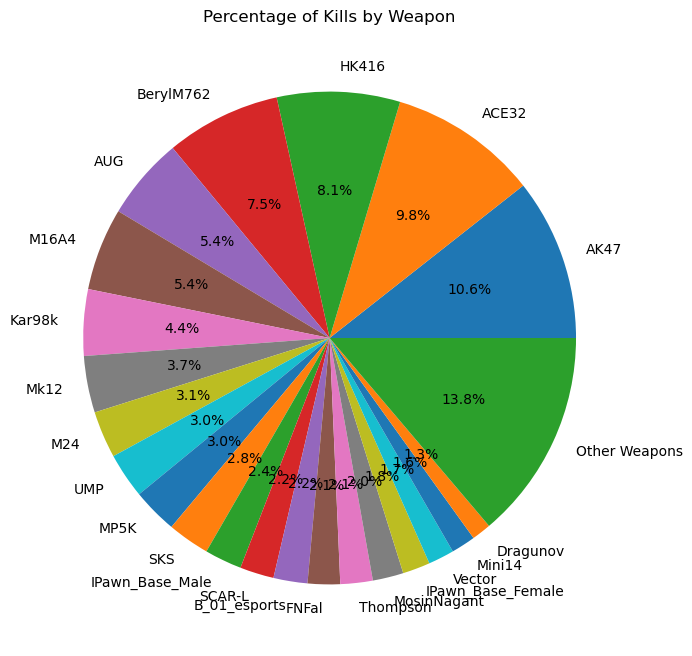

In [172]:
amt = 35
new_row = pd.DataFrame(data = {
    'Weapons Used' : ['Other Weapons'],
    'proportion' : [norm_df.tail(amt)['proportion'].sum()]
})


fixed = norm_df.drop(norm_df.tail(amt).index)

fixed = pd.concat([fixed, new_row])

fig7, ax7 = plt.subplots(figsize=(8,8))
ax7.pie(fixed['proportion'], labels=fixed['Weapons Used'], autopct='%1.1f%%')
ax7.set_title('Percentage of Kills by Weapon')
plt.show()

Same thing but in a pie chart

In [168]:
high_df = pd.DataFrame(bigboy_df[(bigboy_df['Position']<=15)]['Weapons Used'].explode('Weapons Used')).reset_index()
high_df = high_df.value_counts('Weapons Used', dropna=True, normalize=True).reset_index()
high_df.head()

newer_row = pd.DataFrame(data = {
    'Weapons Used' : ['Other Weapons'],
    'proportion' : [high_df.tail(35)['proportion'].sum()]
})
higher_df = pd.DataFrame()

higher_df = high_df.drop(high_df.tail(35).index)

higher_df = pd.concat([higher_df, newer_row])

Here I'm only getting the weapons of top 15 players in each match

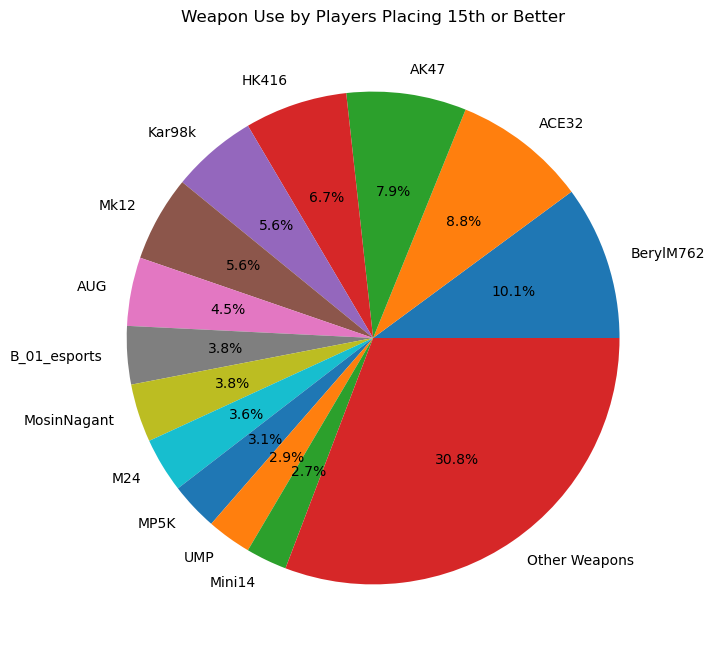

In [84]:
fig10, ax10 = plt.subplots(figsize=(8,8))
ax10.pie(higher_df['proportion'], labels=higher_df['Weapons Used'], autopct='%1.1f%%')
ax10.set_title('Weapon Use by Players Placing 15th or Better')
plt.show()

Something interesting is when you switch to only top 15 players, the BerylM762 goes from 4th popular to first, and the AK47 goes from 1st to 3rd.

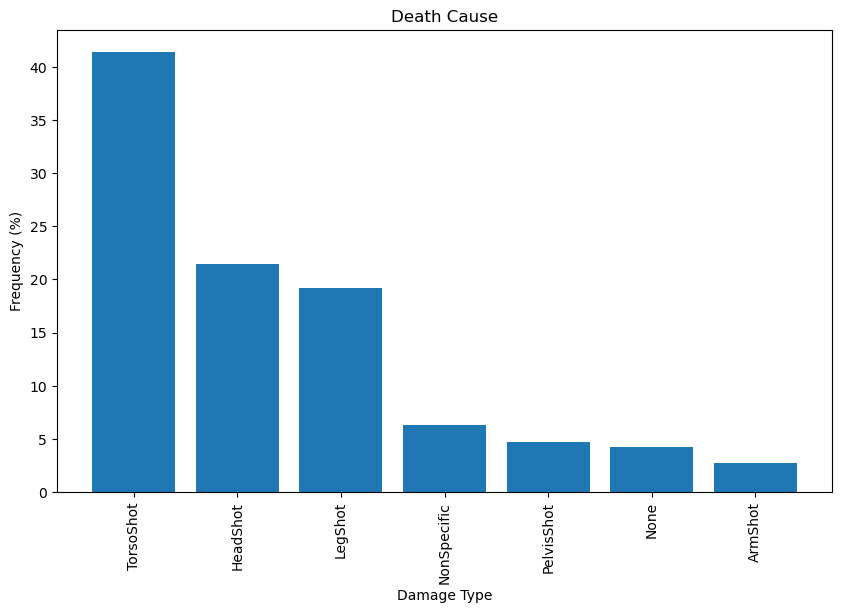

,Death Reason,proportion
0,TorsoShot,0.414013
1,HeadShot,0.214437
2,LegShot,0.192144
3,NonSpecific,0.062633
4,PelvisShot,0.046709
5,None,0.042463
6,ArmShot,0.027601


In [189]:
deaths_df = pd.DataFrame(bigboy_df[bigboy_df['Death Reason']!=''].value_counts('Death Reason', dropna=True, normalize=True).reset_index())
fig15, ax15 = plt.subplots(figsize=(10, 6))

deaths_df
ax15.bar(deaths_df['Death Reason'],deaths_df['proportion']*100)
ax15.set_title('Death Cause')
plt.ylabel('Frequency (%)')
plt.xlabel('Damage Type')
plt.xticks(rotation=90)
plt.show()
deaths_df

Here is death cause by percentage, this makes sense that torso shots are the most popular, as its the biggest hitbox on a character.

In [87]:
#bigboy_df[(bigboy_df['Position']==10)]

In [169]:
cars_df = pd.DataFrame()
fixed = pd.DataFrame(bigboy_df['Vehicle Ridden'].fillna(0))
for x in range(len(bigboy_df)):
    if fixed['Vehicle Ridden'][x]==0:
        cars_df = pd.concat([cars_df, pd.DataFrame({
        "Position": [bigboy_df['Position'][x]],
        "Driven": [0]
        })], ignore_index=True)
    else:
        cars_df = pd.concat([cars_df, pd.DataFrame({
        "Position": [bigboy_df['Position'][x]],
        "Driven": [1]
        })], ignore_index=True)

In [170]:
cars_df.corr()

,Position,Driven
Position,1.000000,-0.366522
Driven,-0.366522,1.000000


There would seem to be a correlation between driving a car at least once in a match and placing higher.

Overall, it seems that players can expect to get farther by avoiding popular cities and using vehicles to their advantage. High ranking players tend to prefer the BerylM762.

Honestly I'm pretty happy with how this turned out, the pandas documentation and stack overflow were truly my best friend throughout this.

<h2>Things to Consider</h2>


- The API documentation is not perfect, and doesn't give great descriptions on everything so I'm going off my knowledge of the game in some places.
- The bots definitely skew this data a ton, but I don't have enough data from exclusively real players to form any conclusions solely based on it.
- This dataset is only 11 matches or so

<h2>Limitations</h2>
<p>I would have liked to have a more expansive dataset for this, especially one with only real players, I think the data would be very different. I am rate limited by the API though so I don't think I could make enough requests to get that much data, also I have to get the match ids manually.</p>

<h2>Next Time</h2>
<p>With more time and knowledge I would want to do the following</p>

- See what weapons are best for short range encounters vs long range ones
- Get care packages working
- See total distance driven
- Have a more expansive dataset to compare AI vs Real players
- Log total encounters for each player
- Death locations by game stage